In [2]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq 

numpy


In [3]:
(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt')
char_to_id,id_to_char = sequence.get_vocab()
vocab_size  =len(char_to_id)
wordec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0
model = Seq2seq(vocab_size,wordec_size,hidden_size)
optimizer = Adam()
trainer = Trainer(model,optimizer)

TypeError: set_ylim() takes from 1 to 5 positional arguments but 26 were given

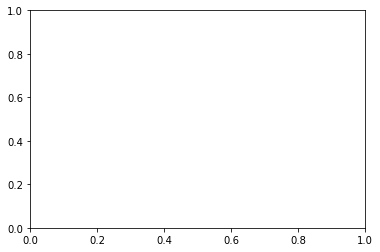

In [4]:
acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train,t_train,max_epoch=1,batch_size=batch_size,max_grad=max_grad)
    correct_num=0
    for i in range(len(x_test)):
        question,correct = x_test[[i]],t_test[[i]]
        verbose = i<10
        correct_num+=eval_seq2seq(model,question,correct,id_to_char,verbose)
    acc = float(correct_num)/len(x_test)
    acc_list.append(acc)
    # print('val acc %.3f%%'%(acc*100))
trainer.plot(acc_list)

In [ ]:
from common.time_layers import *

In [ ]:
class Encoder:
    def __init__(self,vocab_size,wordec_size,hidden_size) -> None:
        V,D,H = vocab_size,wordec_size,hidden_size

        #初始化参数
        embed_w = (np.random.randn(V,D)/100).astype('f')
        lstm_Wx = (np.random.randn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (np.random.randn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')

        #编码器的几个层
        self.embed = TimeEmbedding(embed_w)
        self.lstm = TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=False)

        #参数
        self.params = self.embed.params+self.lstm.params
        self.grads = self.embed.grads+self.lstm.grads

        self.hs = None #每个时间步的隐状态
    
    def forward(self,xs):
        xs = self.embed.forward(xs) #取出某个序列的词向量
        hs = self.lstm.forward(xs)
        self.hs = hs
        return self.hs[:,-1,:]#返回最后一个时间步的隐藏状态
    def backward(self,dh):
        dhs = np.zeros_like(self.hs)
        #初始状态由解码器传来
        dhs[:,-1,:] = dh
        dout = self.lstm.backward(dhs)
        out = self.embed.backward(dout)
        return out

In [ ]:
class Decoder:
    def __init__(self,vocab_size,wordec_size,hidden_size) -> None:
        V,D,H = vocab_size,wordec_size,hidden_size
        #decoder也要学习：故先初始化参数
        embed_w = (np.random.randn(V,D)/100).astype('f')
        lstm_Wx = (np.random.randn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (np.random.randn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_w = (np.random.randn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_w)
        self.lstm = TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=False)
        self.affine = TimeAffine(affine_w,affine_b)
        
        self.params = self.embed.params+self.lstm.params+self.affine.params
        self.grads = self.embed.params+self.lstm.params+self.affine.params
    def forward(self,xs,h):
        self.lstm.set_state(h)
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        out = self.affine.forward(out)
        return out
    def backward(self,dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    def generate(self,h,start_id,sample_size):
        self.lstm.set_state(h)
        sample = []
        sample_id = start_id#当前预测时的输入，把前一个预测结果当作下一次预测的输出
        for _ in range(sample_size):#训练数据获得输出
            x = np.array(sample_id).reshape(1,1)
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            y = self.affine.forward(out)

            sample_id = np.argmax(y.flatten())
            sample.append(int(sample_id))
        return sample


In [ ]:
class seq2seq:
    def __init__(self,vocab_size,wordec_size,hidden_size) -> None:
        V,D,H = vocab_size,wordec_size,hidden_size
        self.encoder = Encoder(V,D,H)
        self.decoder = Decoder(V,D,H)
        self.loss = TimeSoftmaxWithLoss()

        self.params = self.encoder.params+self.decoder.params
        self.grads = self.encoder.params+self.decoder.params
    def forward(self,xs,ts):
        decoder_xs = ts[:,:-1] #训练时使用，包括_
        decoder_ts = ts[:,1:]#判断正误，计算损失，即应该是正确结果，去掉第一个_

        h = self.encoder.forward(xs)
        out = self.decoder.forward(decoder_xs,h)#喂入正确的数据训练
        loss = self.loss.forward(out,decoder_ts)
        return loss
    def backward(self,dout=1):
        dout = self.loss.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    def generate(self,xs,start_id,sample_size):
        h = self.encoder.forward(xs)#先用编码器训练数据得到h
        sample = self.decoder.generate(h,start_id,sample_size)
        return sample

In [ ]:
(x_train,t_train),(x_test,t_test) = sequence.load_data('addition.txt')
char_to_id,id_to_char = sequence.get_vocab()
vocab_size  =len(char_to_id)
wordec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0
model = seq2seq(vocab_size,wordec_size,hidden_size)
optimizer = Adam()
trainer = Trainer(model,optimizer)

In [ ]:
acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train,t_train,max_epoch=1,batch_size=batch_size,max_grad=max_grad)
    correct_num=0
    for i in range(len(x_test)):
        question,correct = x_test[[i]],t_test[[i]]
        verbose = i<10
        correct_num+=eval_seq2seq(model,question,correct,id_to_char,verbose)
    acc = float(correct_num)/len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%'%(acc*100))

In [ ]:
a = np.random.randn
arr = ((2,2) /100).astype('f')
arr